In [592]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR


In [593]:
write_complete_dataframe_path = Path("__file__").parent.joinpath("Manipulated_Data", "Merged_Data").parent.joinpath("Merged_Data", "Merged-Data.csv")
df= pd.read_csv(write_complete_dataframe_path, index_col=0)
df = df[["Date", "Carbon Price"]]
#df = pd.to_datetime(df.Date)
df.set_index("Date", inplace= True)
df.head()

,Carbon Price
Date,
2012-11-09,8.20
2012-11-13,8.49
2012-11-16,6.75
2012-11-20,6.47
2012-11-23,6.75


In [594]:
#df = df[df["Date"] >= "2012-01-01"]
#df = df[df["Date"] <= "2018-12-31"]
df = df[df.index >="2019-01-01"]

<AxesSubplot: xlabel='Date'>

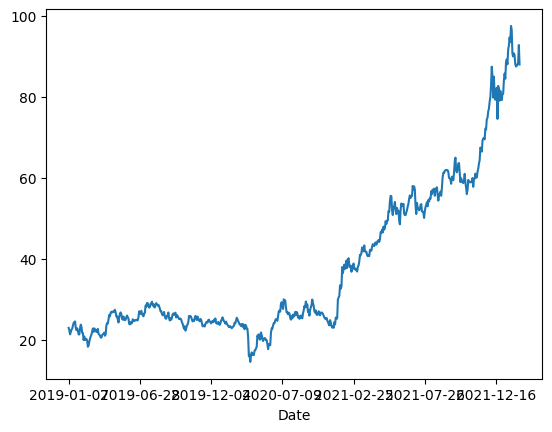

In [595]:
df["Carbon Price"].plot()

In [596]:
train_start_dt = '2019-01-01'
test_start_dt = '2020-6-30 '

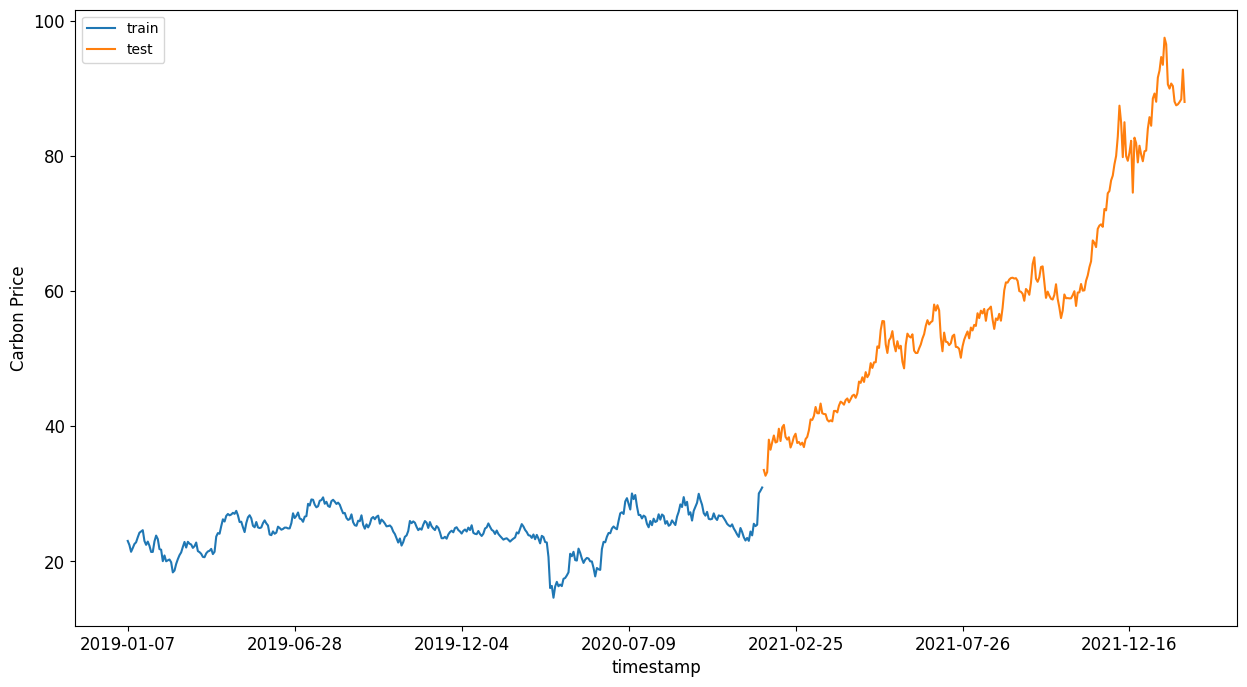

In [597]:
df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['Carbon Price']].rename(columns={'Carbon Price':'train'}) \
    .join(df[test_start_dt:][['Carbon Price']].rename(columns={'Carbon Price':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Carbon Price', fontsize=12)
plt.show()

In [598]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Carbon Price']]
test = df.copy()[df.index >= test_start_dt][['Carbon Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (381, 1)
Test data shape:  (253, 1)


In [599]:
scaler = MinMaxScaler()
train['Carbon Price'] = scaler.fit_transform(train)
train.head(10)

,Carbon Price
Date,
2019-01-07,0.515319
2019-01-08,0.477941
2019-01-10,0.416667
2019-01-14,0.450368
2019-01-15,0.487132
2019-01-16,0.503064
2019-01-17,0.548407
2019-01-21,0.589461
2019-01-22,0.601716


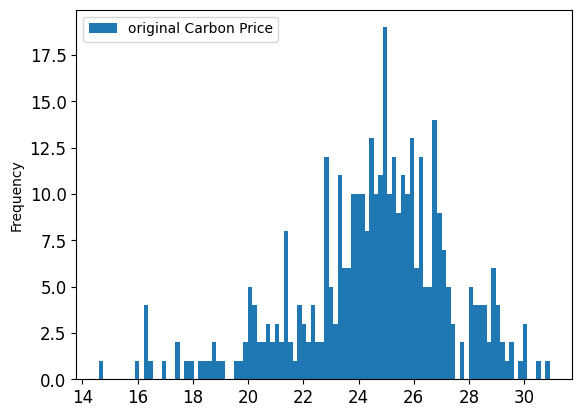

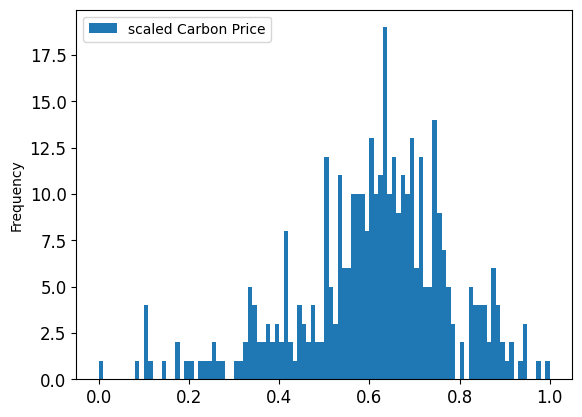

In [600]:
df[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Carbon Price']].rename(columns={'Carbon Price':'original Carbon Price'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Carbon Price':'scaled Carbon Price'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [601]:
test['Carbon Price'] = scaler.transform(test)
test.head()

,Carbon Price
Date,
2021-01-29,1.158701
2021-02-01,1.106618
2021-02-02,1.139706
2021-02-03,1.433824
2021-02-04,1.342525


In [602]:
# Specify the number of steps to forecast ahead
timesteps = 3
train_data = train.values
test_data = test.values

In [603]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(379, 3)

In [604]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(251, 3)

In [605]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(379, 2) (379, 1)
(251, 2) (251, 1)


In [606]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model.fit(x_train, y_train[:,0])
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=10, epsilon=0.05, gamma=0.5, kernel='poly')

In [607]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(379, 1) (251, 1)


In [608]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

379 251


In [609]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

379 251


In [610]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

379 251


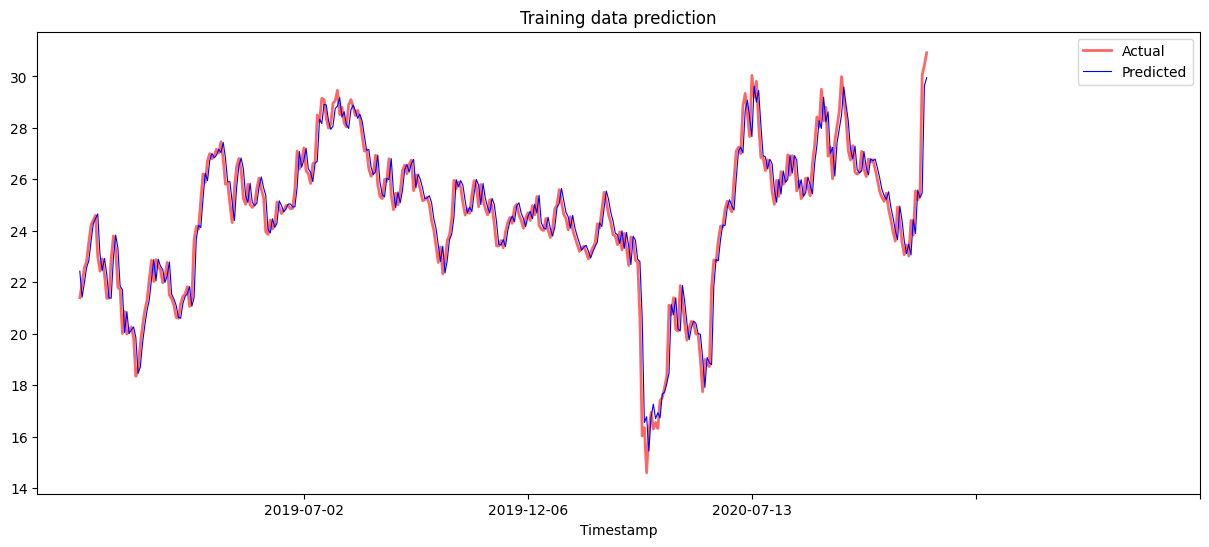

In [611]:
plt.figure(figsize=(15,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks([100, 200, 300, 400, 500])
plt.title("Training data prediction")
plt.show()

In [612]:
def MAPE(Y_Predicted,Y_actual):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [613]:
print('MAPE for training data: ', MAPE(y_train_pred, y_train)*100, '%')

MAPE for training data:  248.12613518464173 %


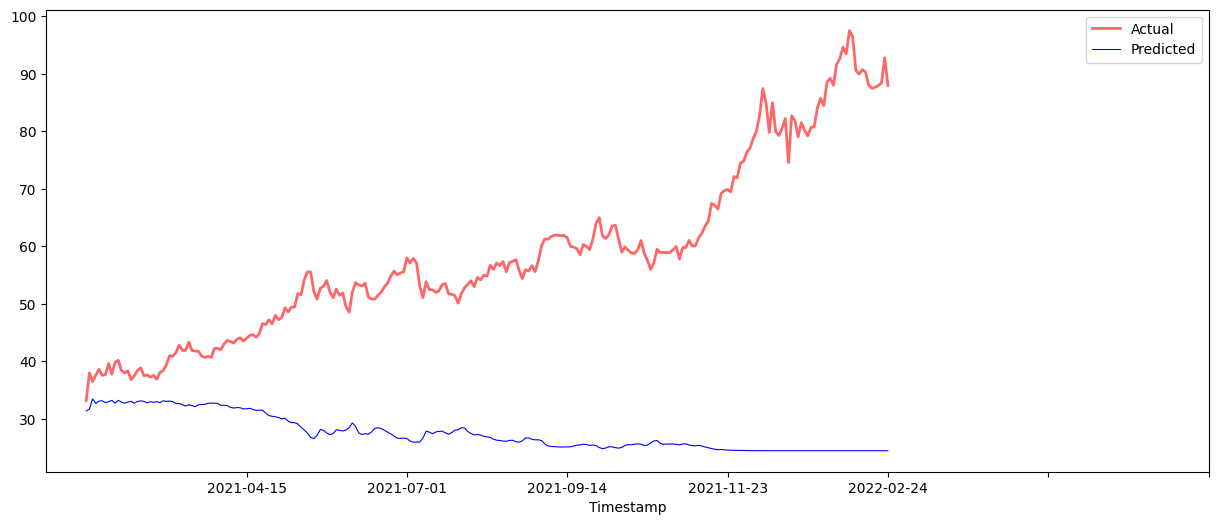

In [614]:
plt.figure(figsize=(15,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xticks([50, 100, 150, 200,250, 300, 350])
plt.xlabel('Timestamp')
plt.show()

In [615]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
print('mean_squared_error : ', mean_squared_error(y_test, y_test_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_test_pred))
print("root_mean_squared_error: ", np.sqrt(mean_squared_error(y_test,y_test_pred)))
print("R^2: " ,r2_score(y_test, y_test_pred))


mean_squared_error :  1268.7228867094077
mean_absolute_error :  30.85450060904175
root_mean_squared_error:  35.61913652391657
R^2:  -4.517198438015376


In [616]:
print('MAPE for testing data: ', MAPE(y_test_pred, y_test)*100, '%')

MAPE for testing data:  4850.06082012686 %


In [617]:
# Extracting load values as numpy array
data = df.copy().values

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (632, 3)
X shape:  (632, 2) 
Y shape:  (632, 1)


C:\Users\rafir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [618]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

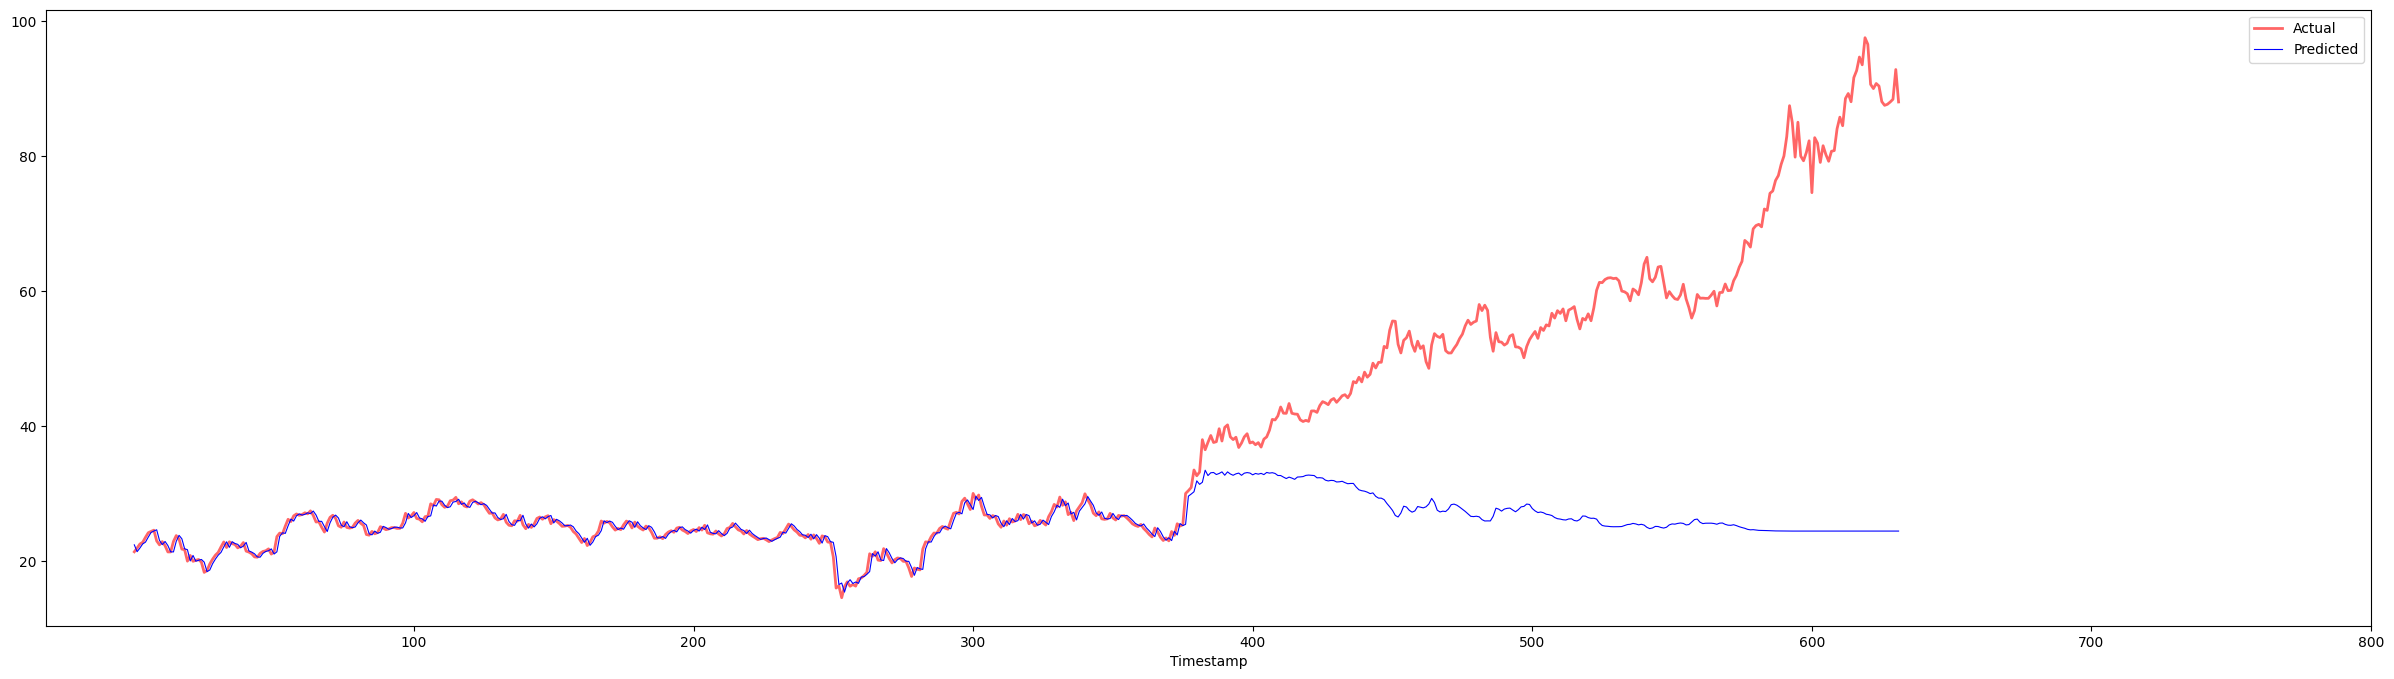

In [619]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xticks([100, 200, 300, 400, 500, 600, 700, 800])
plt.xlabel('Timestamp')
plt.show()

In [620]:
print('MAPE: ', MAPE(Y_pred, Y)*100, '%')


MAPE:  2076.8967879103247 %
